In [1]:
import pandas as pd
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

import plotly.offline as py
py.init_notebook_mode(connected=True)

In [2]:
df=pd.read_csv("data/Diabetes_dataset.csv")
df.head(5)

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,0,6.0,148,72.0,35.0,30.5,33.6,0.627,50.0,1,1
1,1,1.0,85,66.0,29.0,30.5,26.6,0.351,31.0,0,1
2,2,8.0,183,64.0,23.0,30.5,23.3,0.672,32.0,1,1
3,3,1.0,89,66.0,23.0,94.0,28.1,0.167,21.0,0,0
4,4,0.0,137,40.0,35.0,168.0,43.1,0.374,33.0,1,1


# Fairlearn

In [3]:
def età(row):
    if(row["Age"]>25):
        return 'Adult'
    else:
        return 'Young'

In [4]:
df["AgeCategory"]=df.apply(lambda row: età(row), axis=1)

In [5]:
df.head()

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,0,6.0,148,72.0,35.0,30.5,33.6,0.627,50.0,1,Adult
1,1,1.0,85,66.0,29.0,30.5,26.6,0.351,31.0,0,Adult
2,2,8.0,183,64.0,23.0,30.5,23.3,0.672,32.0,1,Adult
3,3,1.0,89,66.0,23.0,94.0,28.1,0.167,21.0,0,Young
4,4,0.0,137,40.0,35.0,168.0,43.1,0.374,33.0,1,Adult


In order to use AIF360, we need first of all to convert all categorical variable into numerical variable. For this reason we replace Adult with number 1, and Young with number 0. 

In [6]:
df=df.replace({"Adult":1})

In [7]:
df=df.replace({"Young":0})

In [8]:
df1=df.copy()

In [9]:
feature_cols=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","AgeCategory"]
X=df[feature_cols]
y=df["Outcome"]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [11]:
classifier = DecisionTreeClassifier()
classifier=classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

In [12]:
age=df["AgeCategory"]
df1=df.copy()
df1=df1.reset_index()
X_test_reset=X_test.reset_index()
X_list=list(X_test_reset["index"])
y_true=df["Outcome"].loc[X_list]
age=df["AgeCategory"].loc[X_list]

In [13]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

In [14]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "true positive rate": recall_score,
    "selection rate": selection_rate,
    "count": count,
}

In [15]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=age
)

array([[<Axes: title={'center': 'accuracy'}, xlabel='AgeCategory'>,
        <Axes: title={'center': 'precision'}, xlabel='AgeCategory'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='AgeCategory'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='AgeCategory'>,
        <Axes: title={'center': 'true positive rate'}, xlabel='AgeCategory'>,
        <Axes: title={'center': 'selection rate'}, xlabel='AgeCategory'>],
       [<Axes: title={'center': 'count'}, xlabel='AgeCategory'>,
        <Axes: xlabel='AgeCategory'>, <Axes: xlabel='AgeCategory'>]],
      dtype=object)

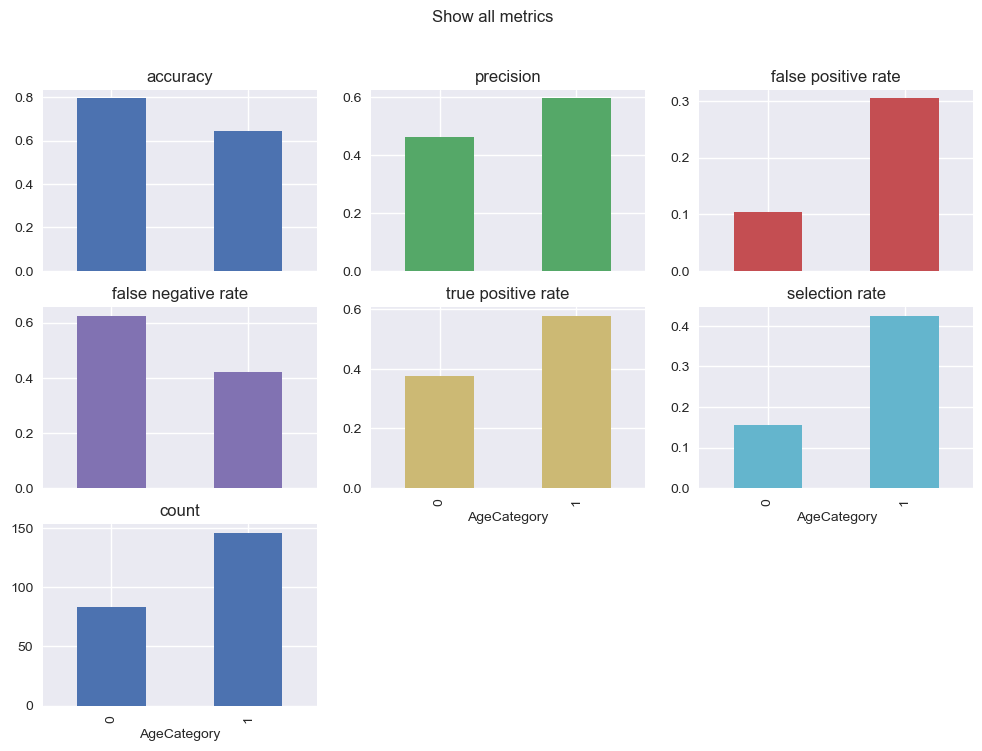

In [16]:
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)


TPR= P( Y=1 | y=1)[Adult] > P(Y=1|y=1)[Young]

FPR=P(Y=1|y=0)[Adult]>P(Y=1|y=0)[Young]

FNR=P(Y=0|y=1)[Young]>P(Y=1|y=0)[Adult]

SR= P(Y=1)

In [17]:
x=metric_frame.by_group
print(metric_frame.by_group)

             accuracy  precision  false positive rate  false negative rate  \
AgeCategory                                                                  
0            0.795181   0.461538             0.104478             0.625000   
1            0.643836   0.596774             0.304878             0.421875   

             true positive rate  selection rate  count  
AgeCategory                                             
0                      0.375000        0.156627   83.0  
1                      0.578125        0.424658  146.0  


In [18]:
dem_parity=demographic_parity_difference(y_true,y_pred,sensitive_features=age)
print("Demographic Parity")
print(demographic_parity_difference(y_true,y_pred,sensitive_features=age))

Demographic Parity
0.26803102822247893


In [19]:
equalize_odds=equalized_odds_difference(y_true, y_pred, sensitive_features=age)
print("Equalize Odds Difference")
print(equalized_odds_difference(y_true, y_pred, sensitive_features=age))

Equalize Odds Difference
0.203125


In [20]:
x["true positive rate"]

AgeCategory
0    0.375000
1    0.578125
Name: true positive rate, dtype: float64

In [21]:
equal_opportunity=x["true positive rate"][1]-x["true positive rate"][0]
print("Equal Opportunity Difference")
print("l'equal opportunity vale ",equal_opportunity)

Equal Opportunity Difference
l'equal opportunity vale  0.203125
